# Average time between commits from scraper

In [1]:
%pip install pandas matplotlib GitPython

You should consider upgrading via the '/home/odi/dev/pyenv3.7/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import git
import os
import datetime
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

# to use different styles, make sure to reload the default to always get clean results
# plt.style.available
def use_style(style):
    plt.style.use('default')
    plt.style.use(style)
    
#display all rows in a dataframe
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [3]:
repo = git.Repo(os.environ.get('REPO_PATH', 'covid_19'), odbt=git.GitCmdObjectDB)

In [144]:
WEEKS = 20
days = WEEKS * 7
start_date = datetime.datetime.today() - datetime.timedelta(days=days)
start_date

datetime.datetime(2020, 6, 3, 9, 39, 3, 77572)

In [156]:
cantons = [
    "AG",
    "AI",
    "AR",
    "BE",
    "BL",
    "BS",
    "FR",
    "GE",
    "GL",
    "GR",
    "JU",
    "LU",
    "NE",
    "NW",
    "OW",
    "SG",
    "SH",
    "SO",
    "SZ",
    "TG",
    "TI",
    "UR",
    "VD",
    "VS",
    "ZG",
    "ZH",
    "FL"
]
data = []
for canton in cantons:
    
    if canton == 'FL':
        commits = list(repo.iter_commits(paths=f'fallzahlen_kanton_total_csv_v2/COVID19_Fallzahlen_{canton}_total.csv', since=start_date.date().isoformat()))
    else:
        commits = list(repo.iter_commits(paths=f'fallzahlen_kanton_total_csv_v2/COVID19_Fallzahlen_Kanton_{canton}_total.csv', since=start_date.date().isoformat()))

    for commit in commits:
        if commit.committer.name == 'GitHub Action Scraper':
            committer = 'Scraper'
        else:
            committer = 'Other'
        date = commit.committed_datetime.replace(tzinfo=None).date()
        data.append({'canton': canton, 'date': date, 'committer': committer})
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df

,canton,date,committer
0,AG,2020-10-20,Scraper
1,AG,2020-10-20,Scraper
2,AG,2020-10-19,Scraper
3,AG,2020-10-19,Scraper
4,AG,2020-10-16,Scraper
...,...,...,...
5189,FL,2020-04-14,Other
5190,FL,2020-04-13,Other
5191,FL,2020-04-12,Other
5192,FL,2020-04-11,Other


In [164]:
def add_additional_cols(df):
    df_new = df.groupby(['date']).count().reset_index()
    df_new = df_new.rename(columns={"canton": "date_count"})
    df_new['diff'] =  df_new['date']- df_new['date'].shift(1)
    df_new['weekday'] = df_new[['date']].apply(lambda x: datetime.datetime.strftime(x['date'], '%A'), axis=1)
    
    return df_new

def add_missing_days(df):
    df_new = df.groupby(['weekday']).count()[['date']].reset_index()
    df_new = df_new.rename(columns={"date": "weekday_count"})
    
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df_new = df_new.set_index(['weekday']).reindex(weekdays, fill_value=0).reset_index()
    mapping = {day: i for i, day in enumerate(weekdays)}
    key = df_new['weekday'].map(mapping)
    df_new = df_new.iloc[key.argsort()]
    return df_new

In [168]:
df_ur = df[df.canton == 'UR'].reset_index(drop=True)
df_ur = add_additional_cols(df_ur)
df_ur

,date,date_count,committer,diff,weekday,weeknumber
0,2020-04-08,1,1,NaT,Wednesday,15
1,2020-04-09,1,1,1 days,Thursday,15
2,2020-04-10,1,1,1 days,Friday,15
3,2020-04-11,1,1,1 days,Saturday,15
4,2020-04-12,1,1,1 days,Sunday,15
...,...,...,...,...,...,...
120,2020-10-12,1,1,3 days,Monday,42
121,2020-10-13,1,1,1 days,Tuesday,42
122,2020-10-14,2,2,1 days,Wednesday,42
123,2020-10-16,1,1,2 days,Friday,42


In [159]:
use_style('fivethirtyeight')
fig, ax = plt.subplots(nrows=len(cantons)/2, ncols=2, figsize=(15,90), dpi=120)
fig.suptitle(f"Weekday of commits\nover last {WEEKS} weeks", fontsize=32, fontweight='bold');

i = 0
for row, canton in enumerate(cantons):
    for j in [0,1]:
        df_canton = df[df.canton == canton].reset_index(drop=True)
        df_canton = add_additional_cols(df_canton)

        mean_time_diff = df_canton['diff'].mean()
        now =  datetime.datetime.now()
        next_commit_date = df_canton[['date']].to_dict('records')[-1]['date'] + mean_time_diff

        diff = next_commit_date - now
        if diff.total_seconds() < -(60*60*24):
            ax[i].text(0.05, 1.1, f"The next commit is overdue since {abs(diff.days)} days, was expected on {next_commit_date.date()}", transform=ax[i].transAxes, bbox=dict(facecolor='red', alpha=0.5))
        else:
            ax[i].text(0.05, 1.1, f"Next commit expected on {next_commit_date.date()} (in {diff.days + 1} days)", transform=ax[i].transAxes, bbox=dict(facecolor='blue', alpha=0.5))


        # commits by scraper
        df_canton_scraper = df[(df.canton == canton) & (df.committer == 'Scraper')].reset_index(drop=True)
        df_canton_scraper = add_additional_cols(df_canton_scraper)
        df_canton_scraper = add_missing_days(df_canton_scraper)

        # commits by others
        df_canton_other = df[(df.canton == canton) & (df.committer == 'Other')].reset_index(drop=True)
        df_canton_other = add_additional_cols(df_canton_other)
        df_canton_other = add_missing_days(df_canton_other)

        # weekdays
        df_canton_weekday = pd.merge(df_canton_scraper, df_canton_other, on='weekday', suffixes=('_scraper', '_other'))

        ax[i].set_title(label=canton, pad=36, loc='left', fontdict={"fontsize": 25, "fontweight": 'bold'})
        ax[i].set_ylabel('Number of commits')
        ax[i].set_xlabel('Weekday')
        ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))

        df_canton_weekday.plot(kind='bar', x='weekday', y=['weekday_count_scraper', 'weekday_count_other'], stacked=True, ax=ax[i], label=('Scraper', 'Others'))

        # Matplotlib idiom to reverse legend entries 
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(reversed(handles), reversed(labels))

        #ax[i].legend().set_visible(False)
        ax[i].xaxis.label.set_visible(False)
        plt.setp(ax[i].get_xticklabels(), rotation=0, ha='center')
    i = i + 1

#fig.subplots_adjust(hspace=0.4)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.97])
plt.show()

TypeError: 'float' object cannot be interpreted as an integer

<Figure size 1800x10800 with 0 Axes>

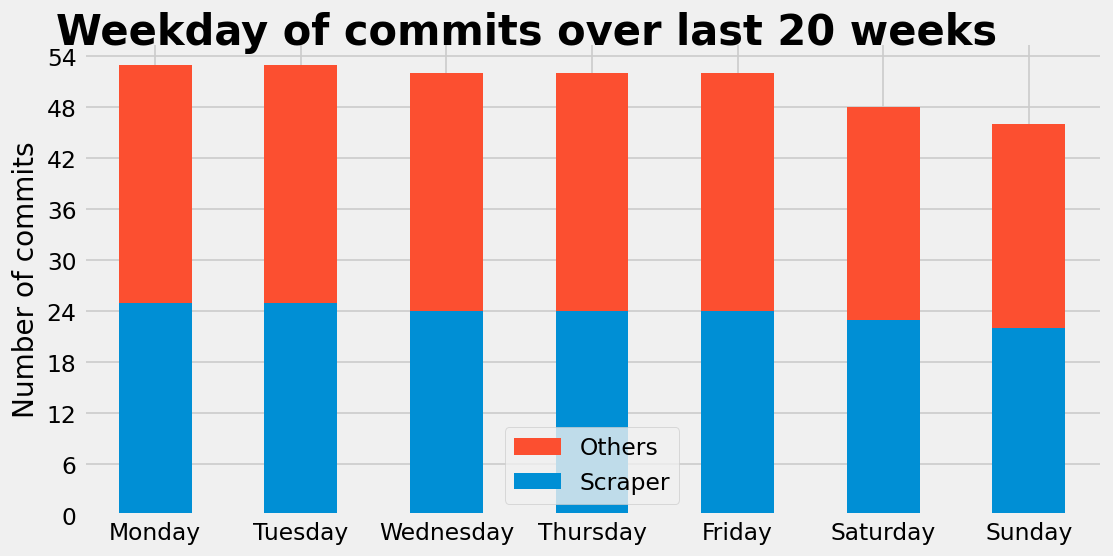

In [160]:
use_style('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,5), dpi=120)
fig.suptitle(f"Weekday of commits over last {WEEKS} weeks", fontsize=25, fontweight='bold');


# commits by scraper
df_scraper = df[(df.committer == 'Scraper')].reset_index(drop=True)
df_scraper = add_additional_cols(df_scraper)
df_scraper = add_missing_days(df_scraper)

# commits by others
df_other = df[(df.committer == 'Other')].reset_index(drop=True)
df_other = add_additional_cols(df_other)
df_other = add_missing_days(df_other)

# weekdays
df_weekday = pd.merge(df_scraper, df_other, on='weekday', suffixes=('_scraper', '_other'))

ax.set_ylabel('Number of commits')
ax.set_xlabel('Weekday')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

df_weekday.plot(kind='bar', x='weekday', y=['weekday_count_scraper', 'weekday_count_other'], stacked=True, ax=ax, label=('Scraper', 'Others'))

# Matplotlib idiom to reverse legend entries 
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))

#ax[i].legend().set_visible(False)
ax.xaxis.label.set_visible(False)
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

#fig.subplots_adjust(hspace=0.4)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.97])
plt.show()

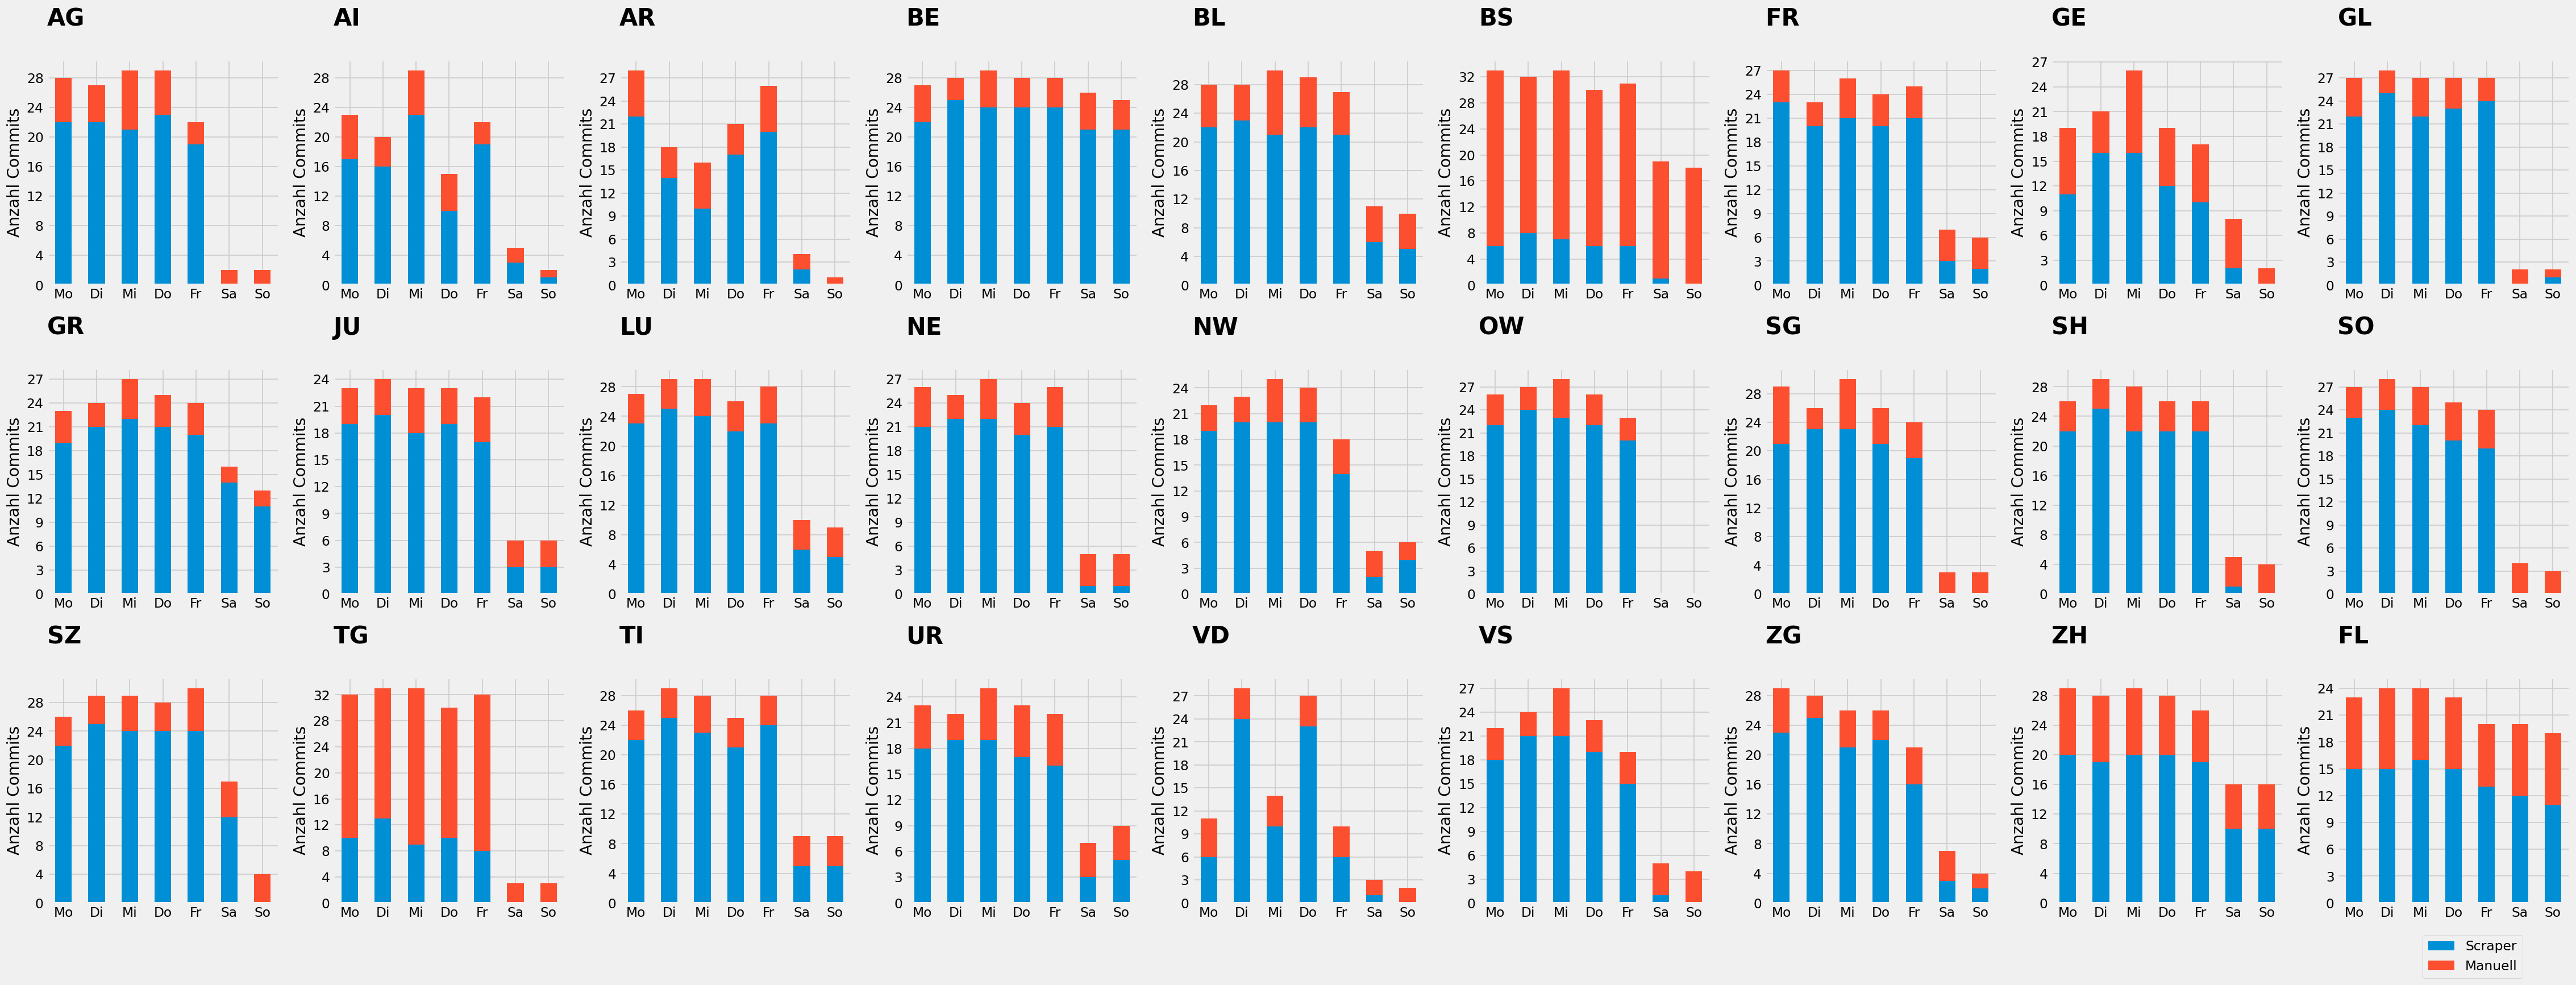

In [163]:
use_style('fivethirtyeight')
fig, ax = plt.subplots(nrows=3, ncols=9, figsize=(40,15), dpi=120)
#fig.suptitle(f"Weekday of commits\nover last {WEEKS} weeks", fontsize=32, fontweight='bold');

i = 0
for row, canton in enumerate(cantons):
    j = row % 9
    
    df_canton = df[df.canton == canton].reset_index(drop=True)
    df_canton = add_additional_cols(df_canton)

    # commits by scraper
    df_canton_scraper = df[(df.canton == canton) & (df.committer == 'Scraper')].reset_index(drop=True)
    df_canton_scraper = add_additional_cols(df_canton_scraper)
    df_canton_scraper = add_missing_days(df_canton_scraper)

    # commits by others
    df_canton_other = df[(df.canton == canton) & (df.committer == 'Other')].reset_index(drop=True)
    df_canton_other = add_additional_cols(df_canton_other)
    df_canton_other = add_missing_days(df_canton_other)

    # weekdays
    df_canton_weekday = pd.merge(df_canton_scraper, df_canton_other, on='weekday', suffixes=('_scraper', '_other'))

    ax[i,j].set_title(label=canton, pad=36, loc='left', fontdict={"fontsize": 25, "fontweight": 'bold'})
    ax[i,j].set_ylabel('Anzahl Commits')
    ax[i,j].set_xlabel('Wochentag')
    ax[i,j].yaxis.set_major_locator(MaxNLocator(integer=True))

    df_canton_weekday.plot(kind='bar', x='weekday', y=['weekday_count_scraper', 'weekday_count_other'], stacked=True, ax=ax[i,j], label=('Scraper', 'Others'))

    # Matplotlib idiom to reverse legend entries 
    handles, labels = ax[i,j].get_legend_handles_labels()
    ax[i,j].legend(reversed(handles), reversed(labels))

    ax[i,j].legend().set_visible(False)
    ax[i,j].xaxis.label.set_visible(False)
    plt.setp(ax[i,j].get_xticklabels(), rotation=0, ha='center')    
    ax[i,j].set_xticklabels(['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So'])
    if j == 8:
        i = i + 1


#fig.delaxes(ax[2,8])

handles, labels = ax[0,0].get_legend_handles_labels()
#ax.legend(handles, labels)
fig.legend(
    handles=handles,     # The line objects
    labels=['Scraper', "Manuell"],   # The labels for each line
    ncol=1,            # number of columns for legend
    #borderaxespad=0.2,    # Small spacing around legend box
    loc='lower right',
    bbox_transform=plt.gcf().transFigure,
    bbox_to_anchor=(0,0,0.98,0.97)
)
#fig.subplots_adjust(hspace=0.4)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.97])
plt.show()

In [232]:
start_date = datetime.datetime(2020, 3, 25)
data = []
for canton in cantons:
    
    commits = list(repo.iter_commits(paths=f'scrapers/scrape_{canton.lower()}.py', since=start_date.date().isoformat()))

    for commit in commits:
        date = commit.committed_datetime.replace(tzinfo=None).date()
        data.append({'canton': canton, 'date': date})
df_scraper = pd.DataFrame(data)
df_scraper['date'] = pd.to_datetime(df_scraper['date'])
df_scraper['weeknumber'] = df_scraper[['date']].apply(lambda x: datetime.datetime.strftime(x['date'], '%V'), axis=1)
df_scraper

,canton,date,weeknumber
0,AG,2020-10-15,42
1,AG,2020-10-14,42
2,AG,2020-10-13,42
3,AG,2020-10-05,41
4,AG,2020-09-28,40
5,AG,2020-09-27,39
6,AG,2020-08-14,33
7,AG,2020-08-10,33
8,AG,2020-08-05,32
9,AG,2020-08-05,32


In [233]:
df_scraper = df_scraper.groupby(['date', 'weeknumber', 'canton']).size().reset_index(name='commit_count')
df_scraper = df_scraper[['date', 'weeknumber', 'canton']].reset_index(drop=True)
df_scraper

,date,weeknumber,canton
0,2020-04-04,14,AG
1,2020-04-04,14,AI
2,2020-04-04,14,AR
3,2020-04-04,14,BE
4,2020-04-04,14,BL
5,2020-04-04,14,BS
6,2020-04-04,14,FR
7,2020-04-04,14,GE
8,2020-04-04,14,GL
9,2020-04-04,14,GR


In [234]:
df_scraper = df_scraper.groupby(['weeknumber', 'canton']).size().reset_index(name="day_count")
df_scraper

,weeknumber,canton,day_count
0,14,AG,1
1,14,AI,1
2,14,AR,1
3,14,BE,1
4,14,BL,1
5,14,BS,1
6,14,FR,1
7,14,GE,1
8,14,GL,1
9,14,GR,1


In [235]:
df_scraper[df_scraper.weeknumber == '14']

,weeknumber,canton,day_count
0,14,AG,1
1,14,AI,1
2,14,AR,1
3,14,BE,1
4,14,BL,1
5,14,BS,1
6,14,FR,1
7,14,GE,1
8,14,GL,1
9,14,GR,1


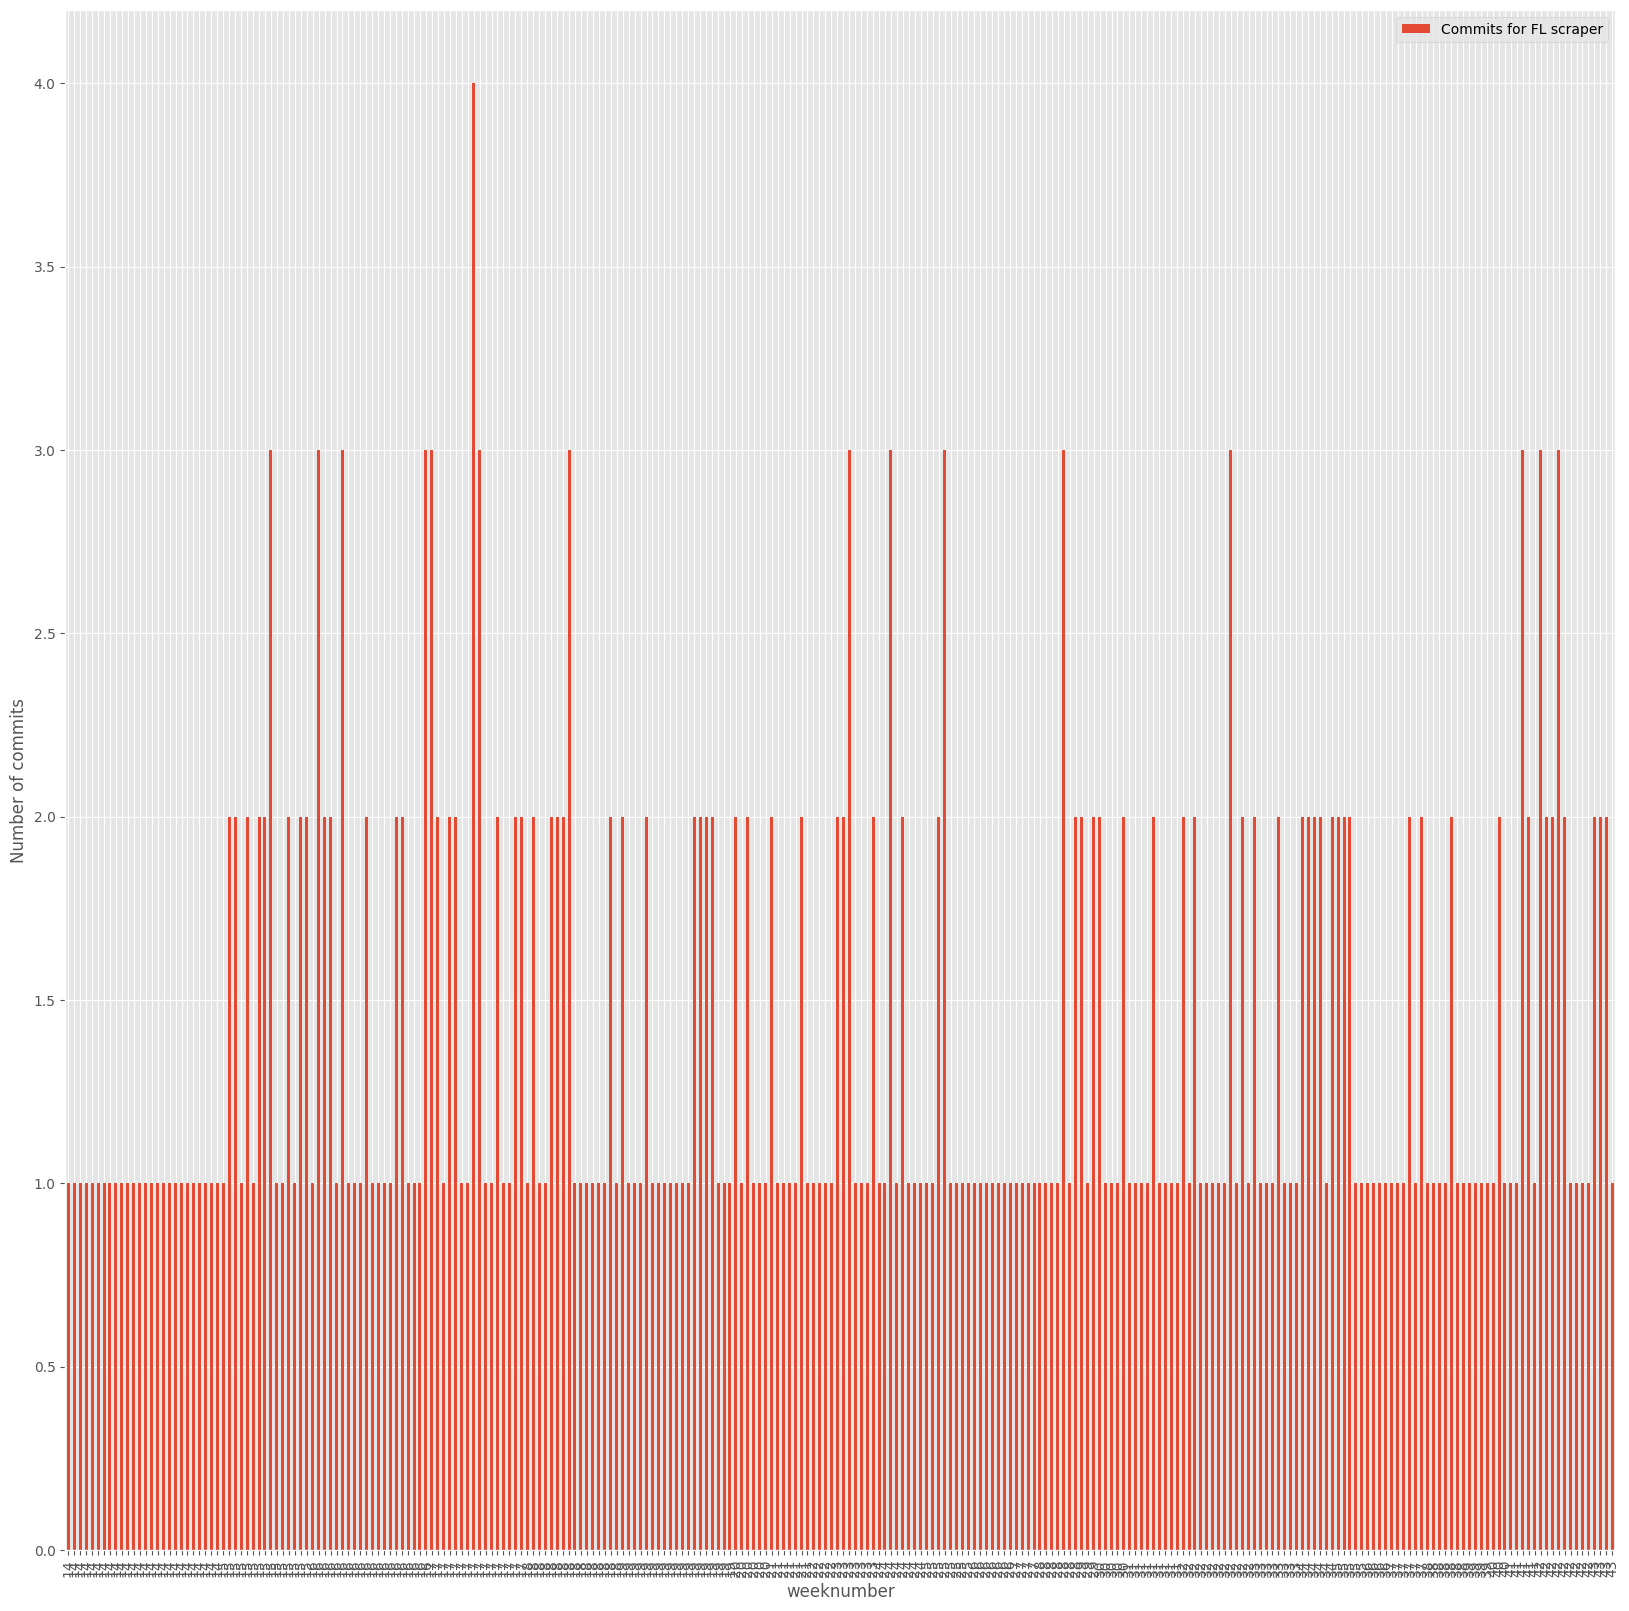

In [237]:
use_style('ggplot')
fig, ax = plt.subplots(figsize=(20,20))

df_scraper_canton = df_scraper[df_scraper.canton == canton].reset_index(drop=True)

#for canton in cantons:
    #df_scraper_canton = df_scraper[df_scraper.canton == canton].reset_index(drop=True)
    #df_canton_scraper = df[(df.canton == canton) & (df.committer == 'Scraper')].reset_index(drop=True)
    #df_canton_weekday = pd.merge(df_canton_scraper, df_canton_other, on='weekday', suffixes=('_scraper', '_other'))
    
ax.set_ylabel('Number of commits')
ax.set_xlabel('Date of commits')
df_scraper.plot(kind='bar', y='day_count', x="weeknumber", label=f"Commits for {canton} scraper", ax=ax)
plt.show()

,canton,committer
date,,
2020-10-20,AG,Scraper
2020-10-20,AG,Scraper
2020-10-19,AG,Scraper
2020-10-19,AG,Scraper
2020-10-16,AG,Scraper
...,...,...
2020-04-20,AG,Fabian Vogler
2020-04-20,AG,Fabian Vogler
2020-04-15,AG,Fabian Vogler


In [139]:
df_scraper_canton = df_scraper_canton.drop(columns=['canton'])
df_scraper_canton

,date,count
0,2020-04-04,4
1,2020-04-06,2
2,2020-04-07,4
3,2020-04-29,2
4,2020-05-26,2
...,...,...
95,2020-10-13,2
96,2020-10-14,2
97,2020-10-15,3
98,2020-10-16,2


In [140]:

df_scraper_canton

,count,date
2020-03-25,0,2020-03-25
2020-03-26,0,2020-03-26
2020-03-27,0,2020-03-27
2020-03-28,0,2020-03-28
2020-03-29,0,2020-03-29
...,...,...
2020-10-16,2,2020-10-16
2020-10-17,0,2020-10-17
2020-10-18,0,2020-10-18
2020-10-19,4,2020-10-19


In [141]:
df_scraper_canton.reset_index(drop=True)

,count,date
0,0,2020-03-25
1,0,2020-03-26
2,0,2020-03-27
3,0,2020-03-28
4,0,2020-03-29
...,...,...
205,2,2020-10-16
206,0,2020-10-17
207,0,2020-10-18
208,4,2020-10-19


In [142]:
df_scraper_canton[df_scraper_canton.date == '2020-04-04']

,count,date
2020-04-04,4,2020-04-04
